In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from simtk import openmm as mm
from simtk.openmm import app
import simtk.unit as unit

# Two Lennard-Jones atoms in vacuum

Let's take two Lennard_Jones atoms in a periodic cubic box with the following parameters:

In [3]:
# Particle 1 with Ar atom values
mass_1 = 39.948 * unit.amu
sigma_1 = 3.404 * unit.angstroms
epsilon_1 = 0.238 * unit.kilocalories_per_mole

# Particle 2 with Xe atom values
mass_2 = 131.293 * unit.amu
sigma_2 = 3.961 * unit.angstroms
epsilon_2 = 0.459 * unit.kilocalories_per_mole

Construction of reduced sigma and epsilon:

\begin{equation}
\sigma_{red} = \frac{\sigma_{1}+\sigma_{2}}{2}
\end{equation}

\begin{equation}
\epsilon_{red} = \sqrt{\epsilon_{1} \epsilon_{2}}
\end{equation}

In [4]:
reduced_sigma = 0.5*(sigma_1+sigma_2)
reduced_epsilon = np.sqrt(epsilon_1*epsilon_2)

Reduced mass of a two particles system with masses $m_1$ and $m_2$:

\begin{equation}
m_{red} = \frac{m_{1} * m_{2}}{m_{1} + m_{2}}
\end{equation}

In [5]:
reduced_mass = (mass_1*mass_2) / (mass_1+mass_2)

Position of minimum:

\begin{equation}
x_{min} = 2^{1/6} \sigma_{red}
\end{equation}

In [6]:
x_min = 2**(1/6)*reduced_sigma

In [7]:
x_min

Quantity(value=4.133466492899267, unit=angstrom)

Time period of small oscillations around the minimum:

\begin{equation}
\tau = \frac{\pi}{3·2^{1/3}} \sqrt{\frac{m_{red}\sigma_{red}^2}{\epsilon_{red}}}
\end{equation}

In [8]:
tau = (np.pi/(3*2**(1/3))) * np.sqrt((reduced_mass*reduced_sigma**2)/reduced_epsilon)
print(tau)

1.4404534295370355 ps


Or taking $\tau/\sqrt(2)$ as reference for the sake of the integration time step threshold estimation:

In [9]:
print(tau/np.sqrt(2))

1.0185543880090564 ps


Potential energy surface:

In [10]:
def LJ (x, sigma, epsilon):
    
    t = sigma/x
    t6 = t**6
    t12 = t6**2
    
    return 4.0*epsilon*(t12-t6)

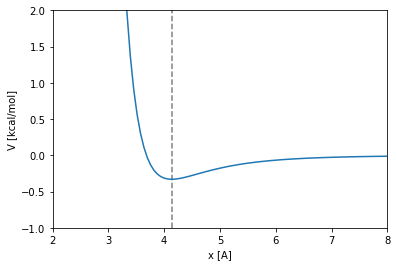

In [11]:
xlim_figure = [2.0, 8.0]
ylim_figure = [-1.0, 2.0]

x = np.linspace(xlim_figure[0], xlim_figure[1], 100, True) * unit.angstrom

plt.plot(x, LJ(x, reduced_sigma, reduced_epsilon))
plt.vlines(x_min._value, ylim_figure[0], ylim_figure[1], linestyles='dashed', color='gray')
plt.xlim(xlim_figure)
plt.ylim(ylim_figure)
plt.xlabel('x [{}]'.format(x.unit.get_symbol()))
plt.ylabel('V [{}]'.format(reduced_epsilon.unit.get_symbol()))
plt.show()

## Working with this test system

This test system is fully documented in [TwoLJParticles class API](../api/_autosummary/uibcdf_test_systems.TwoLJParticles.html). Let's see an example of how to interact with it:

In [12]:
from openmolecularsystems import TwoLJParticles

coordinates=[[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]*unit.nanometers
box=[[2.0, 0.0, 0.0], [0.0, 2.0, 0.0], [0.0, 0.0, 2.0]]*unit.nanometers

# Particle 1 with Ar atom values
mass_1 = 39.948 * unit.amu
sigma_1 = 3.404 * unit.angstroms
epsilon_1 = 0.238 * unit.kilocalories_per_mole

# Particle 2 with Xe atom values
mass_2 = 131.293 * unit.amu
sigma_2 = 3.961 * unit.angstroms
epsilon_2 = 0.459 * unit.kilocalories_per_mole

open_molecular_system = TwoLJParticles(mass_1=mass_1, sigma_1=sigma_1, epsilon_1=epsilon_1,
                                       mass_2=mass_2, sigma_2=sigma_2, epsilon_2=epsilon_2,
                                       coordinates=coordinates, box=box)

In [13]:
open_molecular_system.parameters

{'mass_1': Quantity(value=39.948, unit=dalton),
 'sigma_1': Quantity(value=3.404, unit=angstrom),
 'epsilon_1': Quantity(value=0.238, unit=kilocalorie/mole),
 'mass_2': Quantity(value=131.293, unit=dalton),
 'sigma_2': Quantity(value=3.961, unit=angstrom),
 'epsilon_2': Quantity(value=0.459, unit=kilocalorie/mole)}

In [14]:
open_molecular_system.coordinates

Quantity(value=array([[0., 0., 0.],
       [1., 0., 0.]]), unit=nanometer)

In [15]:
open_molecular_system.box

Quantity(value=array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]]), unit=nanometer)

In [16]:
open_molecular_system.topology

In [17]:
open_molecular_system.system

<simtk.openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x7fbbc4107210> >

Let's check that the molecular system behaves as it was predicted above with the reduced mass, sigma and epsilon constants.

In [18]:
from openmolecularsystems.tools import get_potential_energy

In [26]:
get_potential_energy(open_molecular_system)

Quantity(value=-0.013760010711848736, unit=kilojoule/mole)

In [27]:
coordinates = np.zeros([2,3], float) * unit.angstroms

x = np.linspace(xlim_figure[0], xlim_figure[1], 100, True) * unit.angstrom
V = [] * unit.kilocalories_per_mole

for xi in x:
    coordinates[1,0] = xi
    potential_energy = get_potential_energy(open_molecular_system, coordinates=coordinates)
    V.append(potential_energy)

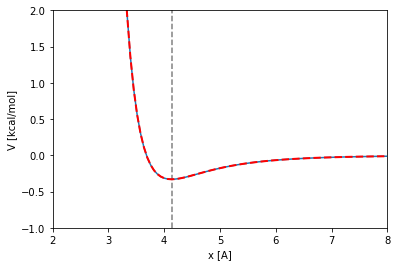

In [31]:
xlim_figure = [2.0, 8.0]
ylim_figure = [-1.0, 2.0]

V._value = np.array(V._value)

plt.plot(x, LJ(x, reduced_sigma, reduced_epsilon))
plt.plot(x, V, linewidth=2, linestyle='--', color='red')
plt.vlines(x_min._value, ylim_figure[0], ylim_figure[1], linestyles='dashed', color='gray')
plt.xlim(xlim_figure)
plt.ylim(ylim_figure)
plt.xlabel('x [{}]'.format(x.unit.get_symbol()))
plt.ylabel('V [{}]'.format(reduced_epsilon.unit.get_symbol()))
plt.show()

In [33]:
open_molecular_system.get_coordinates_minimum()

Quantity(value=4.133466492899267, unit=angstrom)

In [34]:
open_molecular_system.get_small_oscillations_time_period_around_minimum()

Quantity(value=1.4404534295370355, unit=picosecond)

As final tip, there's a shortcut if the particules are real atoms such as argon and xenon. You don't need to remember or look for their sigmas and epsilons:

In [66]:
open_molecular_system = TwoLJParticles(atom_1='Ar', atom_2='Xe',
                                       coordinates=coordinates, box=box)

In [67]:
open_molecular_system.parameters

{'mass_1': Quantity(value=39.948, unit=dalton),
 'sigma_1': Quantity(value=3.404, unit=angstrom),
 'epsilon_1': Quantity(value=0.238, unit=kilocalorie/mole),
 'mass_2': Quantity(value=131.293, unit=dalton),
 'sigma_2': Quantity(value=3.961, unit=angstrom),
 'epsilon_2': Quantity(value=0.459, unit=kilocalorie/mole)}

### Newtonian dynamics

In [54]:
from openmolecularsystems.tools.md import newtonian

initial_positions = np.zeros([2, 3], np.float32) * unit.nanometers
initial_positions[1,0] = x_min +0.05 * unit.angstroms

open_molecular_system.set_coordinates(initial_positions)

traj_dict = newtonian(open_molecular_system, time=5.0*unit.picoseconds,
                      saving_timestep=0.01*unit.picoseconds,
                      integration_timestep=0.01*unit.picoseconds)

100%|██████████| 500/500 [00:00<00:00, 1924.63it/s]


Deterministic dynamics simulation:

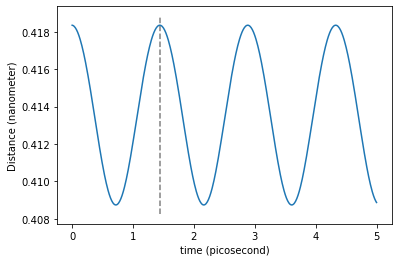

In [55]:
distance = traj_dict['coordinates'][:,1,0]-traj_dict['coordinates'][:,0,0]

plt.plot(traj_dict['time'], distance)
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.vlines(tau._value, y_min, y_max, linestyles='dashed', color='gray')
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('Distance ({})'.format(distance.unit))
plt.show()

### Stochastic Dynamics

Thanks to the `tools.md.langevin_NVT` method in this library, a simple newtonian dynamics can be run with few efforce:

In [61]:
from openmolecularsystems.tools.md import langevin_NVT

initial_positions = np.zeros([2, 3], np.float32) * unit.nanometers
initial_positions[1,0] = 1.0 * unit.nanometers

open_molecular_system.set_coordinates(initial_positions)

traj_dict = langevin_NVT(open_molecular_system, time=10.0*unit.nanoseconds,
                         saving_timestep=1.0*unit.picoseconds,
                         integration_timestep=0.01*unit.picoseconds,
                         friction=1.0/unit.picoseconds, temperature=300.0*unit.kelvin
                         )

100%|██████████| 1000000/1000000 [00:16<00:00, 59726.57it/s]


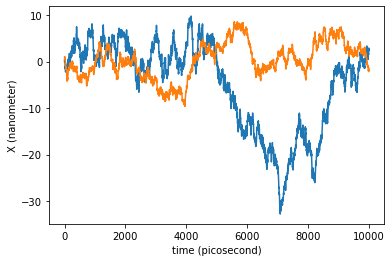

In [60]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,1,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

The output coordinates are not wrapped into the periodic box, but this can be easily done with the library MolSysMT:

In [ ]:
import molsysmt as msm

wrapped_coordinates = msm.wrap(traj_dict)

Let's also check the evolution in time of the distance between both particles. This can also be computed with MolSysMT:

In [ ]:
distance = msm.distance(traj_dict, selection=0, selection_2=0)

-------------

**Sources**

http://docs.openmm.org/6.3.0/userguide/theory.html#lennard-jones-interaction
https://openmmtools.readthedocs.io/en/0.18.1/api/generated/openmmtools.testsystems.LennardJonesPair.html
https://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.testsystems.LennardJonesFluid.html
https://gpantel.github.io/computational-method/LJsimulation/